## Read in and do simple analysis of LUMIP simulations

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Import CMIP6 output

In [2]:
import intake

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


Catalog on cloud has more output (glade not up to date?)

In [3]:
#catalog = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
catalog = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")

Search for the experiments/variables, then futher refine by models (source_id) and ensemble members (member_id)
Looks like there isn't really any hist-noLu data available so playing around with deforest-globe instead (see cells below)

In [ ]:
#sr_nbp = catalog.search(experiment_id=['historical','hist-noLu'], variable_id='nbp', 
#                        source_id=['CanESM5', 'CESM2'],
#                        member_id = ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'])
sr_nbp = catalog.search(experiment_id=['historical','hist-noLu'], variable_id='nbp', member_id=['r1i1p1f1'])
sr_nbp

In [4]:
catalog.search(activity_id='LUMIP', table_id='Lmon')
sr_nbp = catalog.search(activity_id='LUMIP', variable_id='nbp', experiment_id=['deforest-globe'])

In [ ]:
catalog.df.head()

In [5]:
import pprint 
uni_dict = sr_nbp.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 1, 'values': ['deforest-globe']},
 'source_id': {'count': 4,
               'values': ['CNRM-ESM2-1', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR']},
 'table_id': {'count': 1, 'values': ['Lmon']}}


In [6]:
sr_nbp.unique('grid_label')

{'grid_label': {'count': 2, 'values': ['gr', 'gn']}}

### Get the fixed variables output, only available for historical simulations (gridcell area, landfrac)
Can subset the models and ensemble members

In [8]:
#  Would be nice if you could use the source ids that you retrieved earlier, rather than list
# every model separetly, but don't know what the syntax should be.
# e.g. something like:
# sr_fx_ctrl_vars = catalog.search(table_id = ['fx'], source_id = sr_nbp.source_id, 
#                                 member_id = ['r1i1p1f1'], 
#                                experiment_id = 'historical', variable_id = ['areacella', 'sftlf'])

sr_fx_ctrl_vars = catalog.search(table_id = ['fx'], source_id = ['CNRM-ESM2-1', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR'], 
                                 member_id = ['r1i1p1f1'], 
                                 experiment_id = 'historical', variable_id = ['areacella', 'sftlf'])

In [9]:
sr_fx_ctrl_vars.unique('grid_label')

{'grid_label': {'count': 2, 'values': ['gn', 'gr']}}

### Convert the searchs to dictionaries

In [10]:
nbp_ds = sr_nbp.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'nbp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [11]:
nbp_ds.keys()

dict_keys(['LUMIP.CCCma.CanESM5.deforest-globe.Lmon.gn', 'LUMIP.CNRM-CERFACS.CNRM-ESM2-1.deforest-globe.Lmon.gr', 'LUMIP.IPSL.IPSL-CM6A-LR.deforest-globe.Lmon.gr', 'LUMIP.NCAR.CESM2.deforest-globe.Lmon.gn'])

In [12]:
fx_ds = sr_fx_ctrl_vars.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [13]:
fx_ds.keys()
# note that this couldn't find the CNRM fx files, how would one efficiently go about figuring out where those
# data might be avaialable.

dict_keys(['CMIP.CCCma.CanESM5.historical.fx.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.fx.gr', 'CMIP.NCAR.CESM2.historical.fx.gn'])

Grab NBP for both models / experiments

In [14]:
nbp_canesm = nbp_ds['LUMIP.CCCma.CanESM5.deforest-globe.Lmon.gn'].nbp
nbp_cnrm = nbp_ds['LUMIP.CNRM-CERFACS.CNRM-ESM2-1.deforest-globe.Lmon.gr'].nbp
nbp_ipsl = nbp_ds['LUMIP.IPSL.IPSL-CM6A-LR.deforest-globe.Lmon.gr'].nbp
nbp_cesm = nbp_ds['LUMIP.NCAR.CESM2.deforest-globe.Lmon.gn'].nbp

In [15]:
nbp_canesm

<xarray.DataArray 'nbp' (member_id: 1, time: 1092, lat: 64, lon: 128)>
dask.array<transpose, shape=(1, 1092, 64, 128), dtype=float32, chunksize=(1, 1092, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * member_id  (member_id) <U8 'r1i1p2f1'
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * time       (time) object 1850-01-16 12:00:00 ... 1940-12-16 12:00:00
Attributes:
    standard_name:  surface_net_downward_mass_flux_of_carbon_dioxide_expresse...
    long_name:      Carbon Mass Flux out of Atmosphere Due to Net Biospheric ...
    comment:        up is changed to down! CFNB*12.011E-9, LUMIP_table_commen...
    units:          kg m-2 s-1
    original_name:  CFNB
    history:        mltby12em9 2019-05-09T01:46:15Z altered by CMOR: Reordere...
    cell_methods:   area: mean where land time: mean
    cell_measures:  area: areacella

Grab landfrac and cell area for both models (different resolutions)

In [16]:
landfrac_cesm = fx_ds['CMIP.NCAR.CESM2.historical.fx.gn'].sftlf
area_cesm = fx_ds['CMIP.NCAR.CESM2.historical.fx.gn'].areacella
landfrac_canesm = fx_ds['CMIP.CCCma.CanESM5.historical.fx.gn'].sftlf
area_canesm = fx_ds['CMIP.CCCma.CanESM5.historical.fx.gn'].areacella
landfrac_ipsl = fx_ds['CMIP.IPSL.IPSL-CM6A-LR.historical.fx.gr'].sftlf
area_ipsl = fx_ds['CMIP.IPSL.IPSL-CM6A-LR.historical.fx.gr'].areacella

### Make weights for global sum
Convert landfrac from % to fraction between 0-1

In [17]:
landUp_cesm = area_cesm * landfrac_cesm / 100
landUp_canesm = area_canesm * landfrac_canesm / 100
landUp_ipsl = area_ipsl * landfrac_ipsl / 100

Check lat diffs between fx vars and output

In [18]:
latdiffs = landUp_cesm.lat.values - nbp_cesm.lat.values # MISMATCH
latdiffs = landUp_canesm.lat.values - nbp_canesm.lat.values # OK
latdiffs = landUp_ipsl.lat.values - nbp_ipsl.lat.values # OK
print(latdiffs)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


CESM needs correction

In [21]:
landUp_cesm_modlat = landUp_cesm # create new landUp
landUp_cesm_modlat.lat.values = nbp_cesm.lat.values # just assign landUp lats to match nbp lats
#print(landUp_cesm_modlat.lat.values - nbp_esm_cesm.lat.values) # sanity checks
#print(landUp_cesm_modlat.lat.values - nbp_ssp_cesm.lat.values)

### Weighted annual means

In [19]:
def weighted_annual_mean(array):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

Convert  to annual fluxes (kgC/m2/y), from kgC/m2/s 

In [20]:
spy = 365 * 24 * 3600

In [23]:
nbp_cesm_amean = weighted_annual_mean(nbp_cesm) * spy
nbp_cesm_amean.attrs['units'] = 'kgC m-2 y-1'
nbp_cesm_amean 
temp = nbp_cesm_amean.values
#print(temp)

In [24]:
nbp_ipsl_amean = weighted_annual_mean(nbp_ipsl) * spy
nbp_ipsl_amean.attrs['units'] = 'kgC m-2 y-1'
nbp_ipsl_amean 
temp = nbp_ipsl_amean.values
#print(temp)

### Calculate global sums
Instantaneous and cumulative

In [40]:
mean_wgt_cesm = nbp_cesm_amean * landUp_cesm_modlat
ann_glob_cesm = mean_wgt_cesm.sum(dim=('lat','lon')) * 1e-12 #convert to Pg/y
# try without weights
ann_glob_cesm = nbp_cesm_amean.sum(dim=('lat','lon')) * 1e-12
ann_glob_cesm.attrs['units'] = 'Pg C y^-1'
cann_glob_cesm = ann_glob_cesm.cumsum(dim='time')
cann_glob_cesm.attrs['units'] = 'Pg C'
ann_glob_cesm

<xarray.DataArray (member_id: 1, time: 80)>
dask.array<mul, shape=(1, 80), dtype=float64, chunksize=(1, 80), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) object 1850-12-15 12:00:00 ... 1929-12-15 12:00:00
Attributes:
    units:    Pg C y^-1

In [45]:
mean_wgt_ipsl = nbp_ipsl_amean * landUp_ipsl
ann_glob_ipsl = mean_wgt_ipsl.sum(dim=('lat','lon')) * 1e-12 #convert to Pg/y
ann_glob_ipsl = nbp_ipsl_amean.sum(dim=('lat','lon')) * 1e-12
ann_glob_ipsl.attrs['units'] = 'Pg C y^-1'
cann_glob_ipsl = ann_glob_ipsl.cumsum(dim='time')
cann_glob_ipsl.attrs['units'] = 'Pg C'

In [52]:
mean_wgt_canesm = nbp_canesm_amean * landUp_canesm
ann_glob_canesm = mean_wgt_canesm.sum(dim=('lat','lon')) * 1e-12 #convert to Pg/y
# try without weights
ann_glob_canesm = nbp_canesm_amean.sum(dim=('lat','lon')) * 1e-12
ann_glob_canesm.attrs['units'] = 'Pg C y^-1'
cann_glob_canesm = ann_glob_canesm.cumsum(dim='time')
cann_glob_canesm.attrs['units'] = 'Pg C'
cann_glob_canesm

<xarray.DataArray (member_id: 1, time: 91)>
dask.array<nancumsum, shape=(1, 91), dtype=float64, chunksize=(1, 91), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r1i1p2f1'
  * time       (time) object 1850-12-16 12:00:00 ... 1940-12-16 12:00:00
Attributes:
    units:    Pg C

### Plot the timeseries

Way to calculate ensemble means

In [47]:
ann_glob_cesm.mean(dim="member_id")
ann_glob_canesm.mean(dim="member_id")
#ann_glob_ipsl.mean(dim="member_id")
ann_glob_cesm

<xarray.DataArray (member_id: 1, time: 80)>
dask.array<mul, shape=(1, 80), dtype=float64, chunksize=(1, 80), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) object 1850-12-15 12:00:00 ... 1929-12-15 12:00:00
Attributes:
    units:    Pg C y^-1

Instantaneous global sums

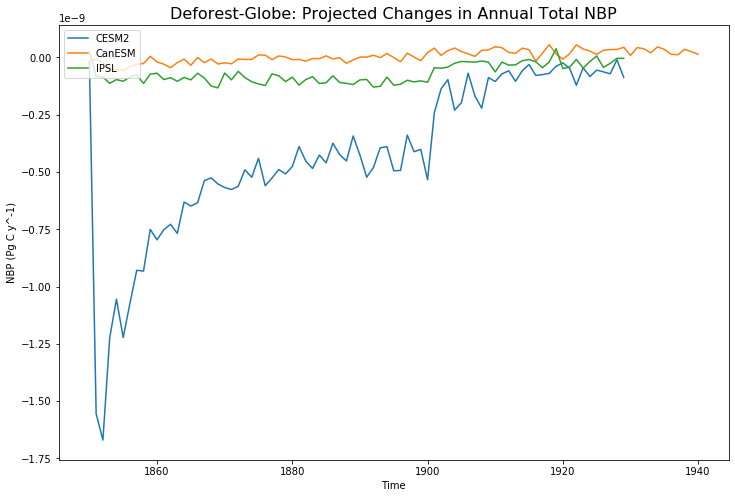

In [49]:
fig = plt.figure(figsize=(12, 8))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob_cesm.coords['time.year'], ann_glob_cesm.mean(dim="member_id"), label='CESM2')
ax.plot(ann_glob_canesm.coords['time.year'], ann_glob_canesm.mean(dim="member_id"), label='CanESM')
ax.plot(ann_glob_ipsl.coords['time.year'], ann_glob_ipsl.mean(dim="member_id"), label='IPSL')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('NBP'+' (' + ann_glob_cesm.attrs['units'] +')')
ax.set_title('Deforest-Globe: Projected Changes in Annual Total NBP', fontdict={'size':16})
ax.legend(loc='upper left');
#plt.savefig('cesm_canesm_ssp585_esm585_nbp.pdf')

Cummulative global sums

NameError: name 'cann_glob_canesm_' is not defined

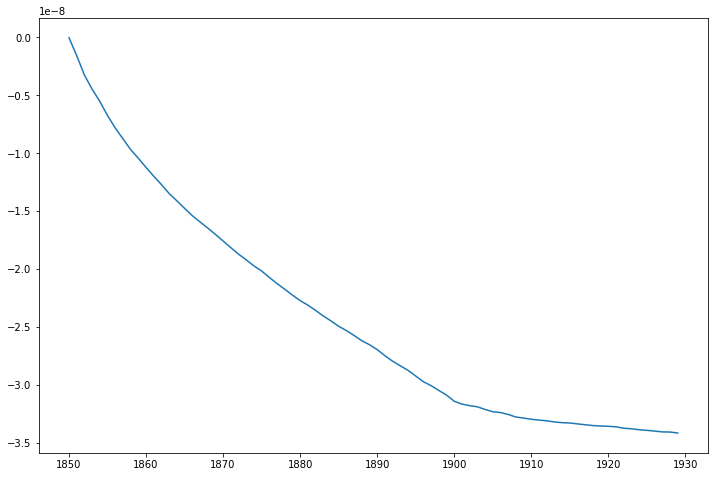

In [51]:
fig = plt.figure(figsize=(12, 8))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(cann_glob_cesm.coords['time.year'], cann_glob_cesm.mean(dim="member_id"), label='CESM2')
ax.plot(cann_glob_canesm.coords['time.year'], cann_glob_canesm_.mean(dim="member_id"), label='CanESM')
ax.plot(cann_glob_ipsl.coords['time.year'], cann_glob_ipsl.mean(dim="member_id"), label='IPSL')

# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel('NBP'+' (' + ann_glob_cesm.attrs['units'] +')')
ax.set_title('Projected Changes in Cumulated Total NBP', fontdict={'size':16})
ax.legend(loc='upper left');
#plt.savefig('cesm_canesm_ssp585_esm585_nbp_cumulative.pdf')